In [652]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore", message="Glyph 12 missing from current font.")



Data #1

In [653]:
data_polling = pd.read_stata("Data/cumulative_2006_2018.dta")

In [654]:
inputs = ['year','st','gender', 'age', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']
targets = ['pid3']

keep = inputs + targets

data_polling = data_polling[(data_polling.year == 2018) & (data_polling.pid3.isin(['Democrat','Republican']) )]

polling = data_polling[keep]

In [655]:
polling.dropna(axis=0, how='any',inplace=True)

In [656]:
pd.options.mode.chained_assignment = None  # default='warn'

polling['age_band'] = np.NaN
polling.loc[ (polling['age'] >= 18) & (polling['age'] <= 29), 'age_band'] = 'Young'
polling.loc[ (polling['age'] >= 30) & (polling['age'] <= 49), 'age_band'] = 'Lower-Middle'
polling.loc[ (polling['age'] >= 50) & (polling['age'] <= 69), 'age_band'] = 'Upper-Middle'
polling.loc[ (polling['age'] >= 70) , 'age_band'] = 'Old'

polling.loc[ polling['pid3'] == "Democrat", "Dem_Ind"] = 1
polling.loc[ polling['pid3'] == 'Republican', "Dem_Ind"] = 0
polling['Dem_Ind'] = polling['Dem_Ind'].astype(int)

categorical_polling = ['st','gender', 'age_band', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']

In [657]:
polling.head()

,year,st,gender,age,race,hispanic,educ,faminc,marstat,economy_retro,newsint,approval_pres,pid3,age_band,Dem_Ind
392756,2018,OH,Female,58,White,No,Post-Grad,150k+,Married,Stayed About The Same,Only Now And Then,Approve / Somewhat Approve,Republican,Upper-Middle,0
392757,2018,KY,Female,66,White,No,Post-Grad,10k - 20k,Divorced,Stayed About The Same,Most Of The Time,Strongly Disapprove,Democrat,Upper-Middle,1
392758,2018,AZ,Female,88,White,No,High School Graduate,20k - 30k,Widowed,Gotten Much Better,Some Of The Time,Approve / Somewhat Approve,Republican,Old,0
392760,2018,NC,Male,71,White,No,High School Graduate,50k - 60k,Married,Gotten Much Better,Some Of The Time,Strongly Approve,Republican,Old,0
392761,2018,PA,Male,86,White,No,4-Year,60k - 70k,Widowed,Gotten Better / Somewhat Better,Most Of The Time,Strongly Approve,Republican,Old,0


In [658]:
small_polling = polling.sample(n=10000, random_state = 42)

X_polling = small_polling[categorical_polling]

y_polling = small_polling.loc[:,'Dem_Ind']

Data #2

In [659]:
# Originall Retrieved From: http://archive.ics.uci.edu/ml/datasets/Adult
# CSV Retrieved From: https://www.kaggle.com/uciml/adult-census-income
# URL: https://drive.google.com/file/d/1wuWJPeacMhHQSXdITZx1_pktoU-ZRb8n/view?usp=sharing
data_income = pd.read_csv("Data/adult.csv")

print(data_income.shape)

(32561, 15)


In [660]:
# Response Variable 
data_income.loc[ data_income['income'] == ">50K", "income"] = 1
data_income.loc[ data_income['income'] == '<=50K', "income"] = 0
data_income['income'] = data_income['income'].astype(int)

In [661]:
# Feature Engineering
data_income['native_USA'] = 0 
data_income.loc[ data_income['native.country'] == "United-States", "native_USA"] = 1
data_income.loc[ data_income['native.country'] != "United-States", "native_USA"] = 0

In [662]:
data_income['native_USA'].value_counts()

1    29170
0     3391
Name: native_USA, dtype: int64

In [663]:
data_income['age_band'] = np.NaN
data_income.loc[ (data_income['age'] <= 29), 'age_band'] = 'Young'
data_income.loc[ (data_income['age'] >= 30) & (data_income['age'] <= 49), 'age_band'] = 'Lower-Middle'
data_income.loc[ (data_income['age'] >= 50) & (data_income['age'] <= 69), 'age_band'] = 'Upper-Middle'
data_income.loc[ (data_income['age'] >= 70) , 'age_band'] = 'Old'

In [664]:
data_income['hours_band'] = np.NaN
data_income.loc[ (data_income['hours.per.week']) < 40, "hours_band"] = 'Low'
data_income.loc[ (data_income['hours.per.week']) == 40, "hours_band"] = 'Average'
data_income.loc[ (data_income['hours.per.week']) > 40, "hours_band"] = 'High'

In [665]:
data_income['hours_band'].value_counts()

Average    15217
High        9581
Low         7763
Name: hours_band, dtype: int64

In [666]:
categorical_income = ['workclass','education','marital.status','occupation','relationship','race','sex','native_USA','age_band','hours_band']


In [667]:
data_income['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [668]:
small_income = data_income.sample(10000,random_state=42)

In [669]:
X_income = small_income[categorical_income]

y_income = small_income.loc[:,'income']


General Use Functions

In [670]:
from sklearn.preprocessing import OneHotEncoder

def prep_data(X, y, categoricalVars):

    encoder = OneHotEncoder(sparse=False)
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categoricalVars]))
    X_encoded.columns = encoder.get_feature_names(categoricalVars)
    X.drop(categoricalVars, axis = 1, inplace = True)
    if X.shape[1] > 0:
        OH_X = pd.concat([X, pd.DataFrame(X_encoded, index=X.index)], axis = 1)
    else:
        OH_X = X_encoded 
        
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(OH_X, y, test_size = .30, train_size = .70, random_state = 42)
    return(X_Train, X_Test, Y_Train, Y_Test)

In [671]:
X_Train_Polling, X_Test_Polling, Y_Train_Polling, Y_Test_Polling = prep_data(X_polling, y_polling, categorical_polling)

In [672]:
X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income = prep_data(X_income, y_income, categorical_income)

### Tutorial for K-Means

Selecting the Number of clusters with silhouette analysis on KMeans Clustering

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

- Silhoutte is a metric used to measure the separation distance between clusters 
- Silhoutte measure ranges from -1 to 1. 
- Silhoutte values near +1: good, sample is far from neighboring cluster
- Silhoutte values near 0: Samples is on or near the decision boundary between two clusters 
- Silhoutte values < 0: Bad, Samples may be assigned to wrong cluster 
- Vary the n_clusters and examine silhoutte metric 

In [673]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import numpy as np 

X, y = make_blobs(n_samples = 500, n_features = 2, centers = 4, cluster_std = 1, center_box = (-10.0, 10.0), shuffle = True, random_state = 1)

print(X.shape)
print(y.shape)

(500, 2)
(500,)


In [674]:
range_n_clusters = [2, 3, 4, 5, 6]

For N clusters: 2 ,The Average silhouette score is : 0.7049787496083262
For N clusters: 3 ,The Average silhouette score is : 0.5882004012129721
For N clusters: 4 ,The Average silhouette score is : 0.6505186632729437
For N clusters: 5 ,The Average silhouette score is : 0.5745566973301872
For N clusters: 6 ,The Average silhouette score is : 0.4387644975296138


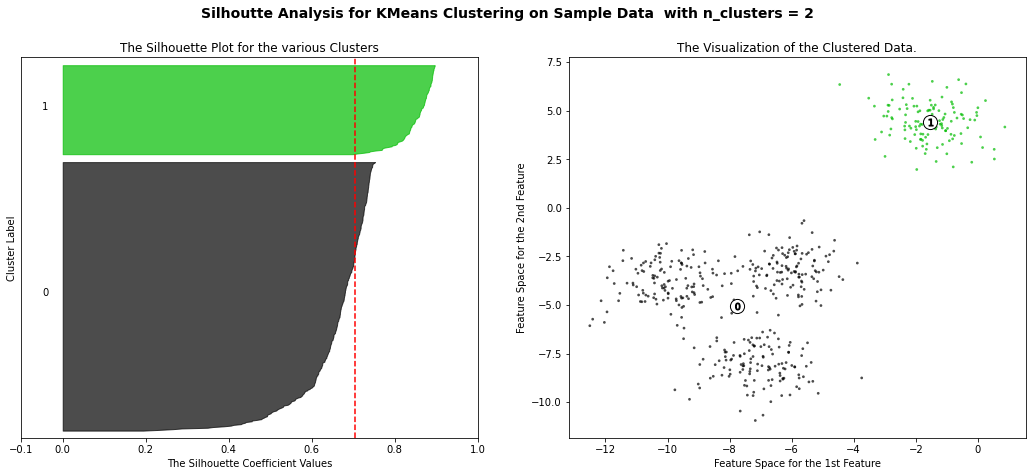

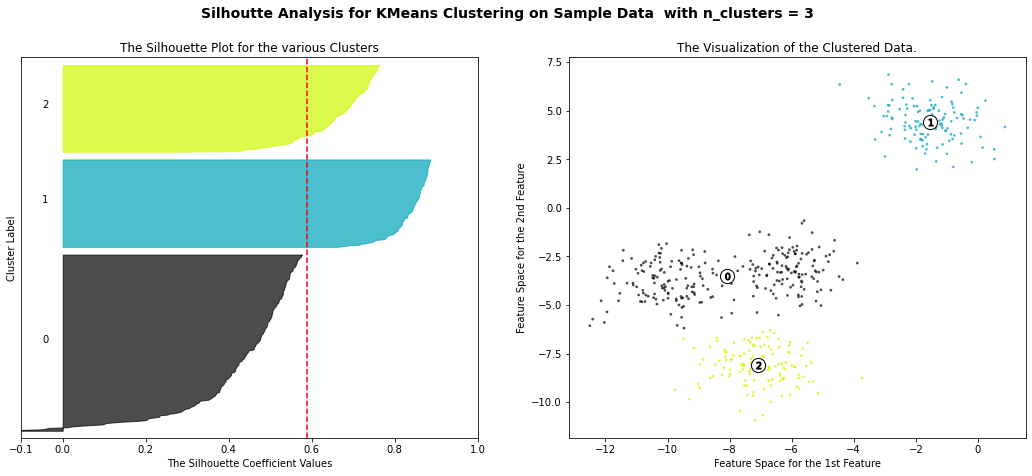

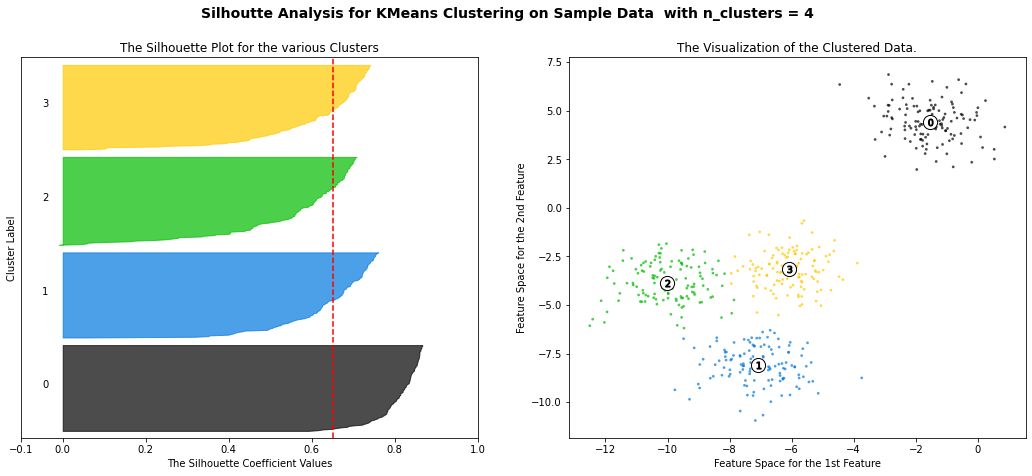

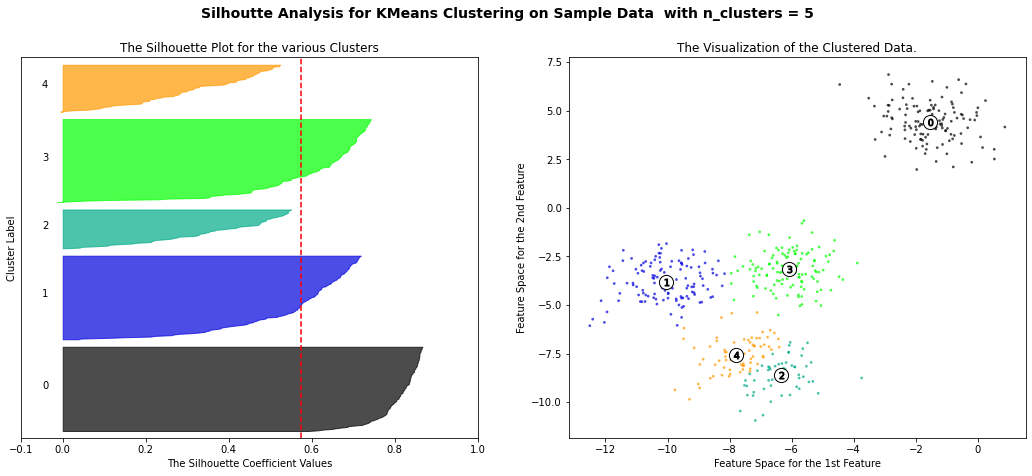

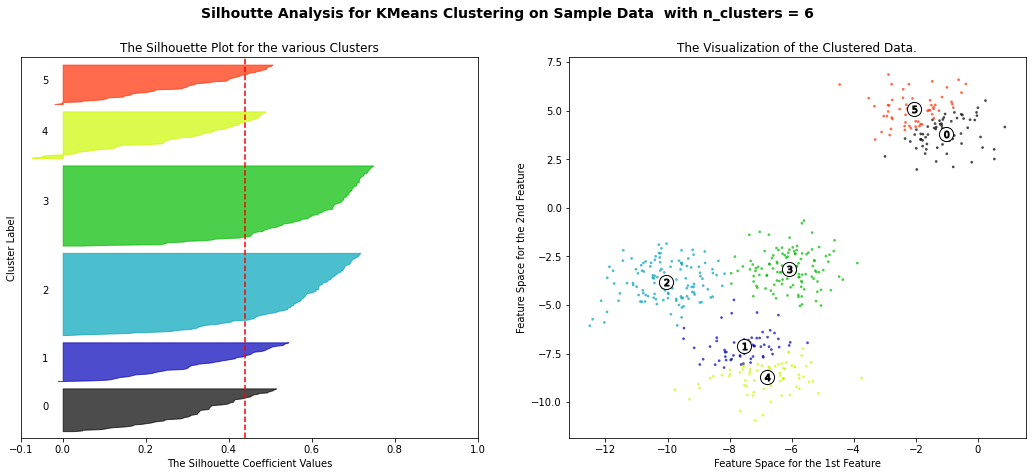

In [675]:
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Silhouette Plot 
    ax1.set_xlim([-.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1)*10])
    
    # initialize the clusterer with the n_clusters value 
    clusterer = KMeans(n_clusters=n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(X)
    
    # Silhouette_score gives avg value for all samples 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For N clusters:", n_clusters, ",The Average silhouette score is :", silhouette_avg)
    
    # Get Silhouette Scores for each sample 
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate scores for samples in the ith cluster, and sort 
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                         facecolor = color, edgecolor = color, alpha = 0.7)
        
        # Label the silhouette plots with the cluster number in the middle 
        ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
        
        # Computer the new y_lower for the next plot 
        y_lower = y_upper + 10 # Without this step, plots are all on top of each other 
        
    ax1.set_title("The Silhouette Plot for the various Clusters")
    ax1.set_xlabel("The Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    
    # The Vertical Line for avg. Silhouette Score of all the values 
    ax1.axvline(x = silhouette_avg, color = 'red', linestyle = "--")
    
    ax1.set_yticks([]) # Clear the Y Axis 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot shows the actual clusters formed 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker = ".", s=30, lw=0, alpha=0.7,
               c = colors, edgecolor = 'k')

    # Label the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers 
    ax2.scatter(centers[:, 0], centers[:, 1], marker = 'o', 
               c = 'white', alpha = 1, s = 200, edgecolor = 'k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1, 
                   s = 50, edgecolor = 'k')
    
    ax2.set_title("The Visualization of the Clustered Data.")
    ax2.set_xlabel("Feature Space for the 1st Feature")
    ax2.set_ylabel("Feature Space for the 2nd Feature")
    
    plt.suptitle(("Silhoutte Analysis for KMeans Clustering on Sample Data "
                    " with n_clusters = %d" %n_clusters),
                fontsize = 14, fontweight = 'bold')
    
    
plt.show()

#### Demo K-Means Clustering with MNIST Digits

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [676]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

X_digits, y_digits = load_digits(return_X_y=True)

data = scale(X_digits)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))
labels = n_digits

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
     % (n_digits, n_samples, n_features))

print(82 * '_')

print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    
    #print(estimator.inertia_) 
    #print(metrics.homogeneity_score(y_digits, estimator.labels_))
  
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
      % (name, (time() - t0), estimator.inertia_,
         metrics.homogeneity_score(y_digits, estimator.labels_),
         metrics.completeness_score(y_digits, estimator.labels_),
         metrics.v_measure_score(y_digits, estimator.labels_),
         metrics.adjusted_rand_score(y_digits, estimator.labels_),
         metrics.adjusted_mutual_info_score(y_digits,  estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_,
                                  metric='euclidean',
                                  sample_size=sample_size)))
    


bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.17s	69510	0.610	0.657	0.633	0.481	0.629	0.129
random   	0.16s	69907	0.633	0.674	0.653	0.518	0.649	0.131
PCA-based	0.02s	70768	0.668	0.695	0.681	0.558	0.678	0.142
__________________________________________________________________________________


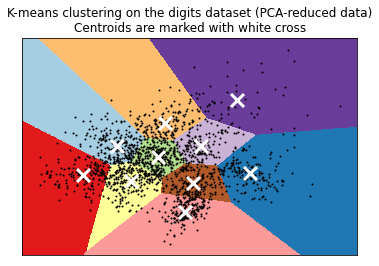

In [677]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Step 1

For KMeans, consider these metrics:
- Inertia (TSS): MINIMIZE the Inertia, or the distance from points to their centers. Find the point where adding more clusters does not decrease the inertia, and use this as optimal clusters
- Silhoutte Score: MAXIMIZE the SScore, this shows us how separate clusters are from another 

In [825]:
def run_kmeans(X_Data, range_num_clusters, title):
      
    n_clusters_list = []
    inertia_list = []
    avg_silhouette_list = []
    
    for n_clusters in range_num_clusters:
        kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Data)
        kmeans_silhouette_avg = silhouette_score(X_Data, kmeans_cluster_labels)

        #print("For N clusters:", n_clusters, ", Average silhouette score is :", kmeans_silhouette_avg, \
        #      ", Average inertia is :", kmeans_clusterer.inertia_)
        
        n_clusters_list.append(n_clusters)
        inertia_list.append(kmeans_clusterer.inertia_)
        avg_silhouette_list.append(kmeans_silhouette_avg)
        
    plt.clf()
    plt.plot(n_clusters_list, inertia_list)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia (TSSE)")
    plt.title("The Effect of Number of Clusters \non Inertia for " + title)
    plt.show()
    #plt.savefig(title + "KMeans Inertia.png")
    
    plt.clf()
    plt.plot(n_clusters_list, avg_silhouette_list)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Average Silhouette Score")
    plt.title("The Effect of Number of Clusters \non Silhouette for " + title)
    plt.show()
    

#### KMeans Data 1

#### Data # 1

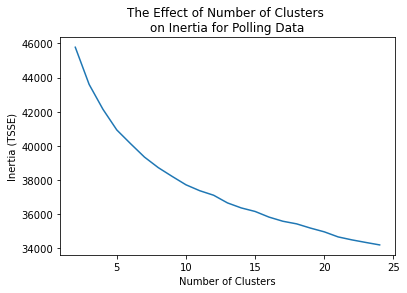

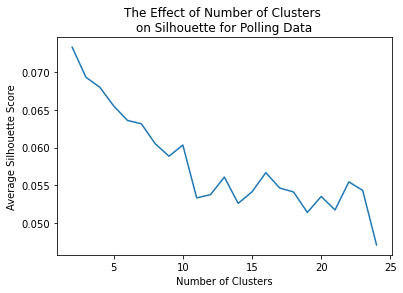

None
31.754945993423462


In [826]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(2, 25, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

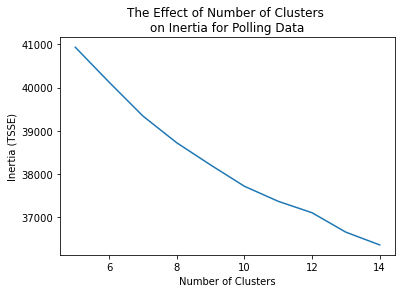

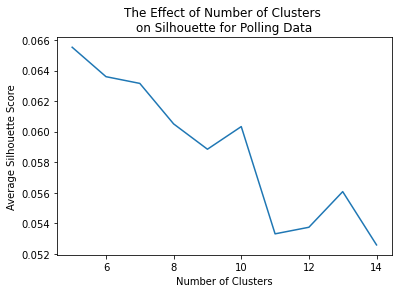

None
13.014554977416992


In [1078]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(5, 15, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

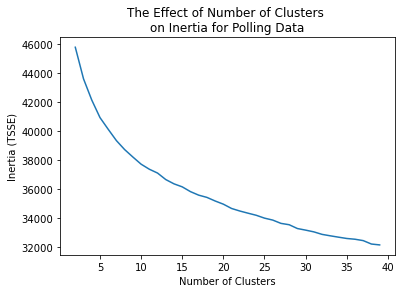

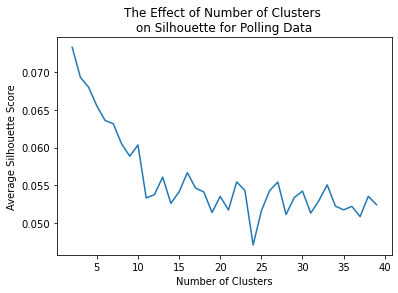

None
63.63605999946594


In [1068]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(2, 40, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

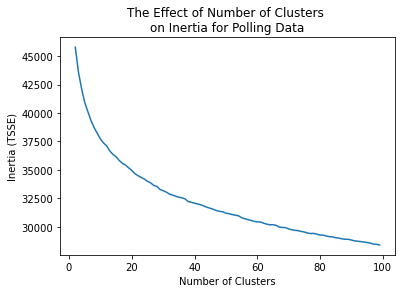

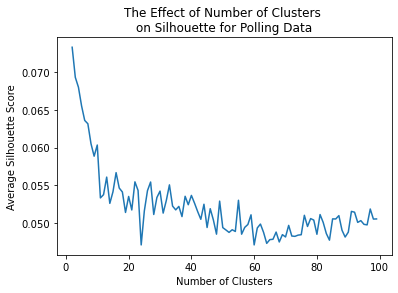

None
247.80576419830322


In [1063]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(2, 100, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

- KMEANS, Data 1, the elbow appears around 10 clusters

#### KMeans Data 2

#### Data #2

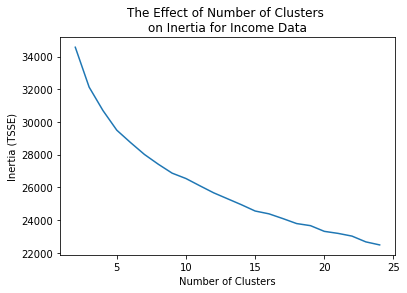

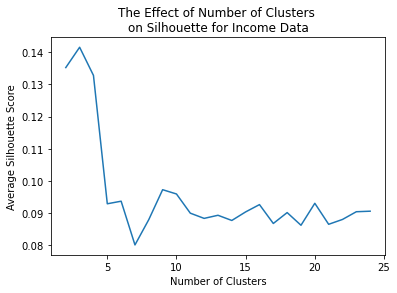

25.47606086730957


In [685]:
start = time.time()

run_kmeans(X_Train_Income, np.arange(2, 25, 1) , "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

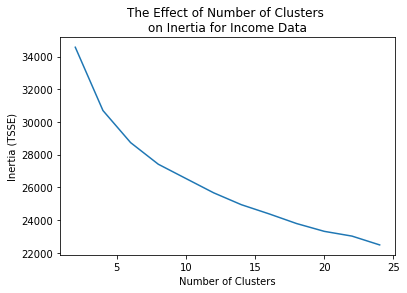

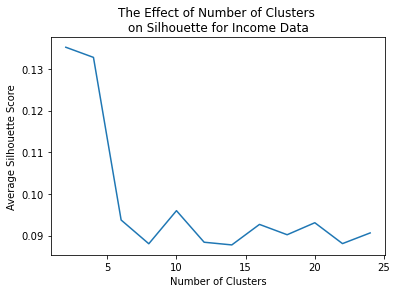

15.797920942306519


In [1074]:
start = time.time()

run_kmeans(X_Train_Income, np.arange(2, 25, 2) , "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- KMEANS, Data 2, the best result seems around 8 clusters

### EM Data 1

In [686]:
from sklearn.mixture import GaussianMixture as EM

def run_em(X_Data, k_list, title, cov_type):
    
    aic_list = []
    bic_list = []
    avg_silhouette_list = []
    n_components_list = []
    
    for k in k_list:
        em = EM(n_components = k, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Data)
        
        n_components_list.append(k)
        avg_silhouette_list.append(silhouette_score(X_Data, em_labels))
        aic_list.append(em.aic(X_Data))
        bic_list.append(em.bic(X_Data))
        
    plt.clf()
    plt.plot(n_components_list, aic_list, label = 'AIC')
    plt.plot(n_components_list, bic_list, label = 'BIC')
    plt.legend()
    plt.xlabel("Number of Components")
    plt.ylabel("Metric Value")
    plt.title("The Effect of the Number of Components \non AIC/BIC for " + title + "\n With " + cov_type + " Covariance")
    plt.show()
    
    print("Silhouettes", avg_silhouette_list)
    
    plt.clf()
    plt.plot(n_components_list, avg_silhouette_list)
    plt.xlabel("Number of Components")
    plt.ylabel("Average Silhouette Score")
    plt.title("The Effect of Number of Components \non Silhouette for " + title + "\n With " + cov_type + " Covariance")
    plt.show()
    
    
        
    

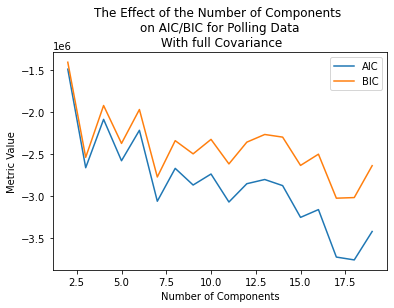

Silhouettes [0.07331336447494478, 0.00698613273306507, 0.051875038725606615, -0.011486348396113474, 0.0395297461686826, -0.006909155162600529, 0.02087705503523868, 0.030807207449398057, 0.04442399174619637, 0.005806846856362122, 0.02612208036996127, 0.01907532237477724, 0.03143621764790719, 0.01515624141556936, 0.004791346509599338, -0.017865590103383098, -0.01636469979595357, -0.001603202597543911]


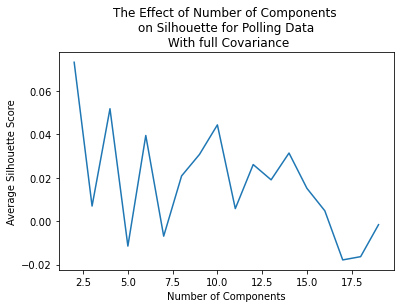

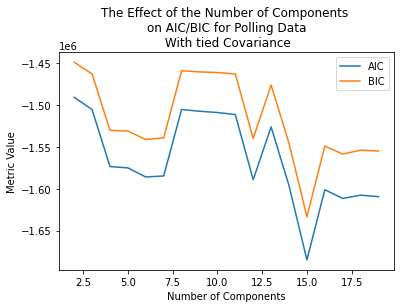

Silhouettes [0.07331336447494478, 0.06721996269174427, 0.061144973092727956, 0.05761510151333007, 0.049017821040354514, 0.05900880306291712, 0.05394549782333094, 0.05616219593945098, 0.05455892570962894, 0.05113524576640826, 0.04739678472316912, 0.04882186787949355, 0.051741714763422465, 0.0514479540990415, 0.038815191821625024, 0.039309557546586195, 0.036232231180831805, 0.039158647101756115]


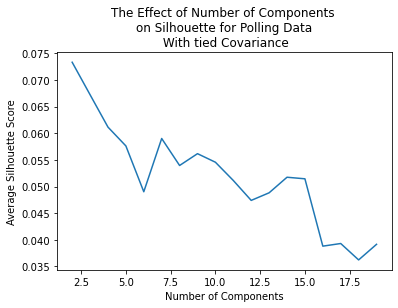

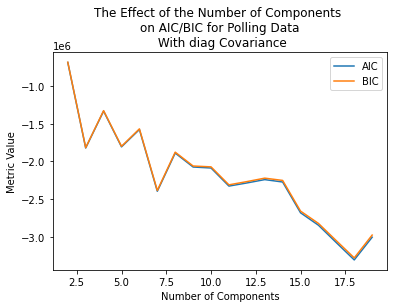

Silhouettes [0.07331336447494478, 0.03724345935510335, 0.05139313939082938, 0.0004928781304198222, 0.037907918902444965, 0.018272480677080438, 0.022731074923603573, 0.0341255237133546, 0.04370950181664999, 0.018416294748368242, 0.025374451806530588, 0.024349779398737736, 0.03169251058580869, 0.018988973678460624, 0.016941530714487323, -0.0013321921467002373, -0.00745860053538402, 0.0012698335041347148]


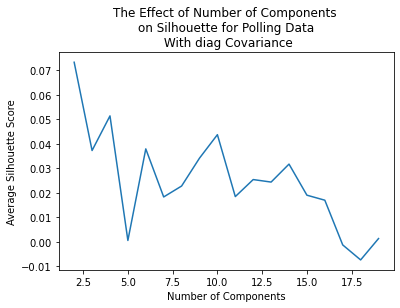

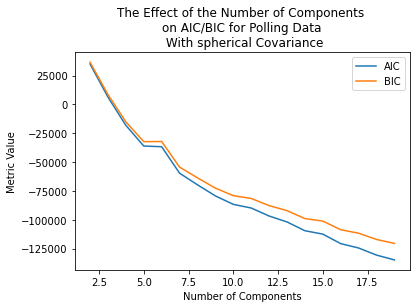

Silhouettes [0.07331336447494478, 0.06319487331299388, 0.05788294687195375, 0.05794035772127549, 0.054343712398820326, 0.05596353536647892, 0.05362456415826981, 0.04866371060659864, 0.05145438723053065, 0.046434166398708725, 0.043834215139829734, 0.04556236282355173, 0.05020698904350978, 0.040869167207301514, 0.040213613165958575, 0.03890615790370158, 0.044938132817007044, 0.04485670676258783]


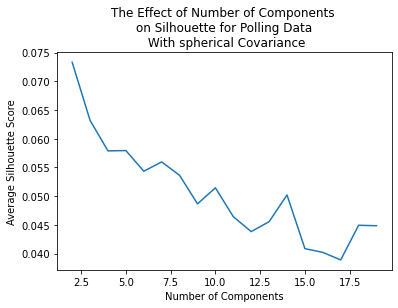

In [687]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    run_em(X_Train_Polling, np.arange(2, 20, 1), "Polling Data", cv)

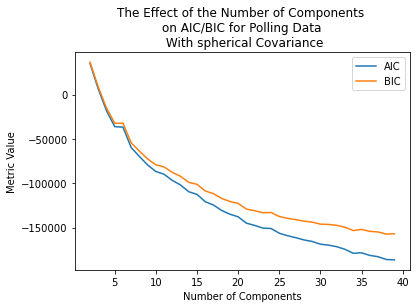

Silhouettes [0.07331336447494478, 0.06319487331299388, 0.05788294687195375, 0.05794035772127549, 0.054343712398820326, 0.05596353536647892, 0.05362456415826981, 0.04866371060659864, 0.05145438723053065, 0.046434166398708725, 0.043834215139829734, 0.04556236282355173, 0.05020698904350978, 0.040869167207301514, 0.040213613165958575, 0.03890615790370158, 0.044938132817007044, 0.04485670676258783, 0.044097112774377306, 0.04933363432323477, 0.047431134978630836, 0.04748201966524574, 0.0411823439891359, 0.04317380494106661, 0.0452503575639396, 0.044935576510732815, 0.045093749694836184, 0.04596835929335827, 0.04642490652816476, 0.04773316540013276, 0.04550031132953598, 0.03732520594672545, 0.04658634791469038, 0.04126923834014522, 0.04321734301681681, 0.04187686244719585, 0.04741426542229754, 0.044268103269053234]


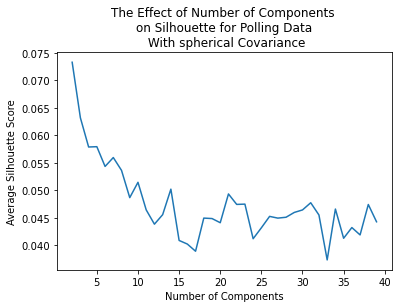

In [1075]:
run_em(X_Train_Polling, np.arange(2, 40, 1), "Polling Data", 'spherical')

Data 1:
- Silhouette Max score occurs for n_components = 2, for all cov_types, at 0.0733
- Highest Silhouette occurs for covariance type = Spherical, highest floor of 0.449 
- BIC/AIC elbow method occurs for n_components = 5, for Spherical, or 3 for others 

#### EM Data #2

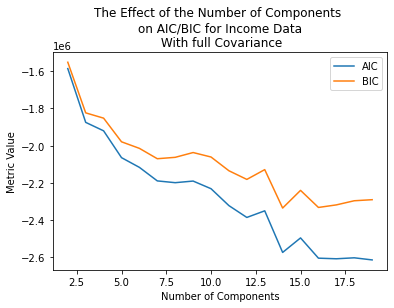

Silhouettes [0.13466498111857916, 0.13836092359564758, 0.08793029878531346, 0.07449548552431004, 0.05559578912520639, 0.0696418871081825, 0.0719009021993622, 0.07622484521388571, 0.07719048780923382, 0.07583011797204935, 0.0676358679689745, 0.07217684246711867, 0.0706457764619524, 0.08148968468868546, 0.06492725547332581, 0.07415930527298721, 0.06451834194331592, 0.06843830415526453]


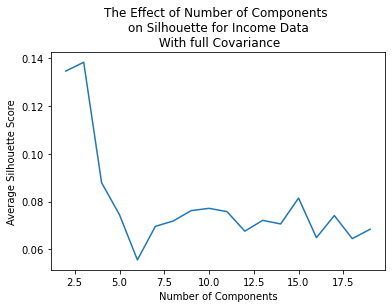

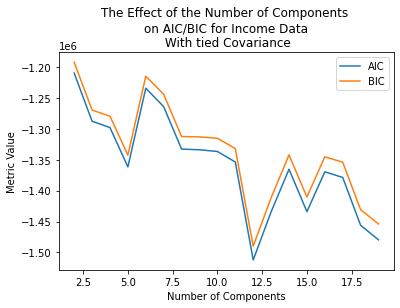

Silhouettes [0.13466498111857916, 0.14180683013810363, 0.08688430599492368, 0.08168459893983496, 0.07688809508269041, 0.07625062253123294, 0.08110905414230672, 0.08055831187923931, 0.07779972395498334, 0.08193202075677007, 0.09218553728477516, 0.08631477682390758, 0.07494092810241147, 0.08544466666748751, 0.06673471813736813, 0.08865013406361917, 0.0805279859752102, 0.09227953784360875]


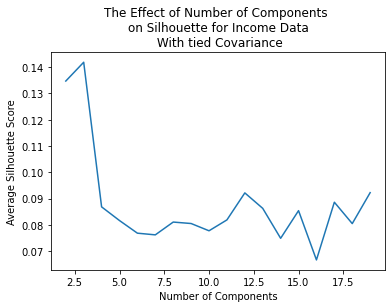

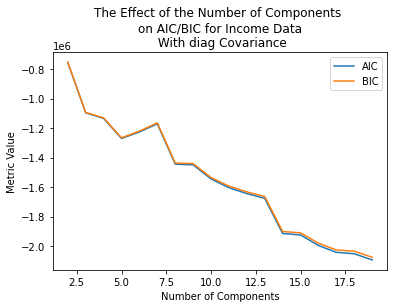

Silhouettes [0.13466498111857916, 0.14020677191000022, 0.09018733884680925, 0.0768417891854639, 0.05898306807801418, 0.07487323641414921, 0.08015193743112073, 0.07760232258075035, 0.07367240498353658, 0.07384601818803206, 0.0796725193096668, 0.07960017951468197, 0.07365748750464525, 0.08085718309545242, 0.06883531313764056, 0.07425137621506855, 0.07035544022925486, 0.06527648708112907]


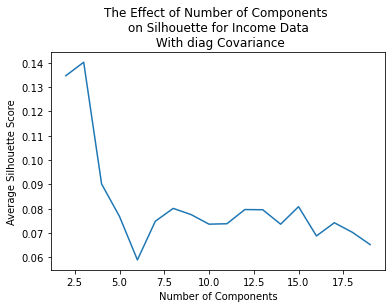

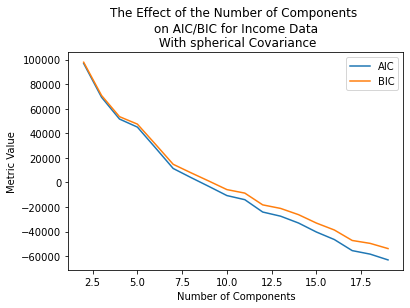

Silhouettes [0.1349776948405022, 0.14020683127411573, 0.08590614399764795, 0.07317888664953463, 0.06676861201494504, 0.07060364435543263, 0.07118010714643837, 0.07231452756456633, 0.06195595137881095, 0.06442353903687241, 0.07179948751058693, 0.06387123894435447, 0.05945573211563395, 0.06914225955482821, 0.04417714795022251, 0.04815904049228644, 0.04189682205107214, 0.04367816936578514]


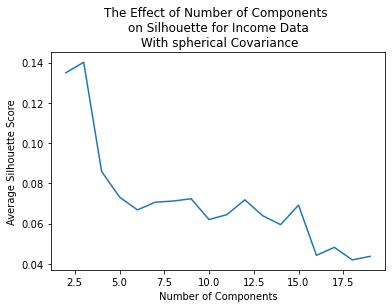

In [688]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    run_em(X_Train_Income, np.arange(2, 20, 1), "Income Data", cv)

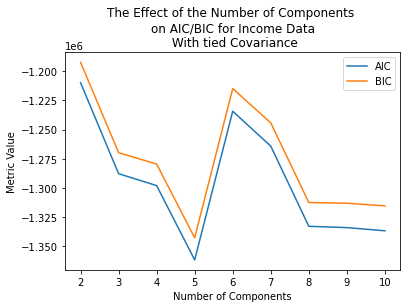

Silhouettes [0.13466498111857916, 0.14180683013810363, 0.08688430599492368, 0.08168459893983496, 0.07688809508269041, 0.07625062253123294, 0.08110905414230672, 0.08055831187923931, 0.07779972395498334]


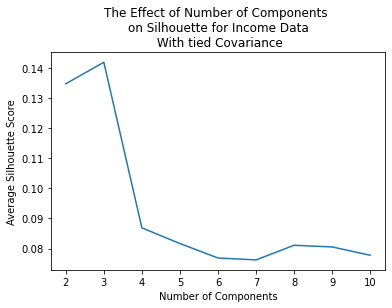

In [1076]:
run_em(X_Train_Income, np.arange(2, 11, 1), "Income Data", 'tied')

Data 2:
- Silhouette Max score occurs for n_components = 3 at 0.142
- Highest Silhouette occurs for covariance type = 'tied'
- BIC/AIC elbow method occurs for n_components = 5, heuristic method shows where decrease slows down

## Step 2) Apply Dimensionality Reduction Algorithms to the Datasets

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

Implement 4 Dimensionality Reduction Algorithms on the 2 Data sets
- PCA: Principal Components Analysis
- ICA: Independent Components Analysis
- RCA: Random Components Analysis 
- RFC: Random Forest Classifier

https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

### 2.1) PCA 

In [689]:
from sklearn.decomposition import PCA 

# No need to use Standard Scaler because we are using Binary Variables 

def run_PCA(X_Data, title):
    
    pca = PCA(n_components = .80, random_state = 42)
    pca.fit(X_Data)

    print("Optimal Number of Components:", pca.n_components_)
    max_feats = X_Data.shape[1]
    #max_feats = pca.n_components_

    plt.clf()
    #fig, (ax1, ax2) = plt.subplots(1,2)
    x = np.arange(1, pca.n_components_ +1)
    y1 = pca.explained_variance_ratio_.cumsum()
    plt.plot(x, y1)
    plt.plot(x, np.repeat(0.8, pca.n_components_), linestyle = '--', color = 'red')
    plt.ylabel("Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.title("The Effect of Number of Components \non Cumulative Explained Variance \nfor "+ title)
    plt.show()
    
    #print(pca.components_)
    #print(pca.singular_values_)
    
    y2 = pca.singular_values_
    plt.clf()
    plt.plot(x, y2)
    plt.xlabel("Number of Components")
    plt.ylabel("Eigenvalues")
    plt.title("The Effect of the Number of Components \non Eigenvalues for " + title)
    plt.show()

Optimal Number of Components: 31


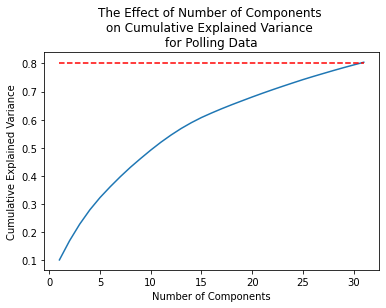

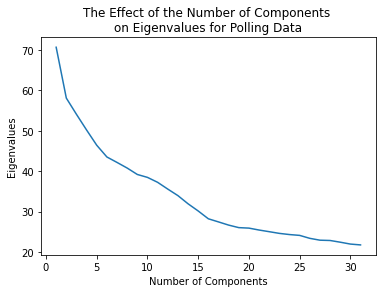

In [690]:
run_PCA(X_Train_Polling, "Polling Data")

Data #1
- Optimal Number of Components is 31

Optimal Number of Components: 19


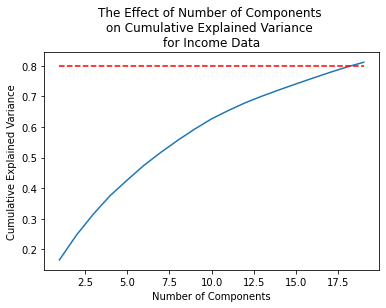

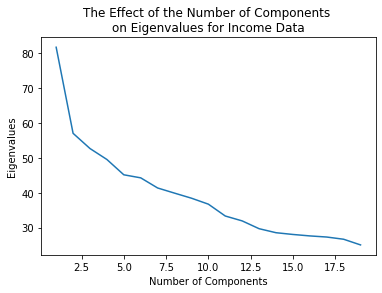

0.2430870532989502


In [691]:
start = time.time()

run_PCA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

Data #2
- Optimal Number of Components is 19
- Higher values of Eigenvalues is better, where n_components is 2 

### 2.2) ICA

ICA chart modified from: https://github.com/kylewest520/CS-7641---Machine-Learning/blob/master/Assignment%203%20Unsupervised%20Learning/CS%207641%20HW3%20Code.ipynb

In [907]:
from sklearn.decomposition import FastICA as ICA 

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

def run_ICA(X_Data, title):
    
    max_feats = X_Data.shape[1]
    
    n_components_list = np.arange(2, max_feats, 1)
    #n_components_list = np.arange(2, 10, 1)
    
    ica = ICA(random_state=42)
    kurtosis_list = []

    for num in n_components_list:
        
        ica.set_params(n_components=num)
        
        X_Transformed = ica.fit_transform(X_Data)
        #print(X_Transformed.shape)
        
        X_Transformed_df = pd.DataFrame(X_Transformed)
        #print(X_Transformed_df.shape)
        
        # Find the Kurtosis Over Requested Acxis, where 0 means find Kurtosis over rows 
        X_Transformed_Kurtosis = X_Transformed_df.kurt(axis=0) # Returns Series 
        
        avg_kurtosis = X_Transformed_Kurtosis.abs().mean()
       
        kurtosis_list.append(avg_kurtosis)
    
    maxElement = np.amax(kurtosis_list)
    result = np.where(kurtosis_list == np.amax(kurtosis_list))
    print("Max Value:",maxElement)
    print("N Components:",result[0][0] +2)
    
    plt.figure()
    plt.title("The Effect of the Indepdent Components \non The Average Kurtosis \nfor "+ title)
    plt.xlabel("Number of Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(n_components_list, kurtosis_list)
    plt.plot(n_components_list, np.repeat(3, len(n_components_list)), linestyle = '--', color = 'red')

    plt.grid(False)
    plt.show()

Max Value: 94.94879791206175
N Components: 98


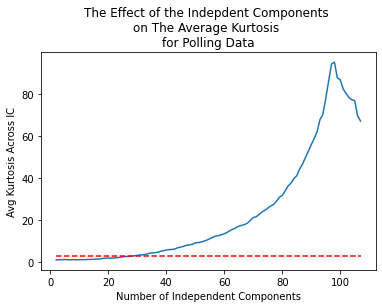

111.35792207717896


In [908]:
start = time.time()

run_ICA(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

- When number of IC components = 30, that is when Kurtosis > 3
- Kurtosis = 3 when a distribution is Normally Distributed
- Kurtosis >> 3 implies that there is a lot of weight in the tails of a distribution, measures many outliers
- ICA did not converge, even with 2000 max iterations, but values did not change by increasing 
- We want the highest absolute value of Kurtosis, this implies the most Non-Gaussian

Max Value: 244.32727740295124
N Components: 61


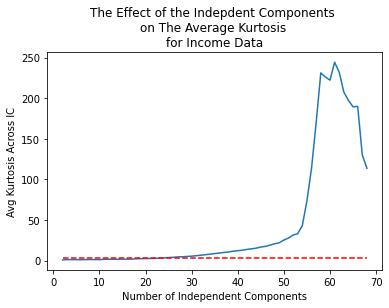

32.414474964141846


In [909]:
start = time.time()

run_ICA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Kurtosis stays much lower in this dataset through around 55 independent components, but then it shoots up over 200 kurtosis, which is much higher than Dataset 1 
- When number of IC equals 24, the Kurtosis Exceeds a value of 3

### 2.3) RCA 

In [1021]:
from sklearn.random_projection import GaussianRandomProjection as GRP

def run_RCA(X_Data, title):
    
    max_feats = X_Data.shape[1]
    n_components_list = np.arange(2, max_feats, 1)
    #n_components_list = np.arange(40, 55, 1)
    
    restarts = np.arange(1, 6, 1)
    list_of_lists = []
    
    for iteration in restarts:
        iterlist = []
        
        for num in n_components_list:

            rpa = GRP(n_components=num, random_state = iteration)

            # Fit to data using on n components 
            X_Reduced = rpa.fit_transform(X_Data)

            # Pseudo Inverse 
            psuedo_inverse = np.linalg.pinv(rpa.components_.T)
            X_Reconstructed = X_Reduced.dot(psuedo_inverse)

            Error_Recon = metrics.mean_squared_error(X_Data, X_Reconstructed)
            iterlist.append(Error_Recon)
            
        list_of_lists.append(iterlist)

    # Plot 1 
    y1 = list_of_lists[0]
    y2 = list_of_lists[1]
    y3 = list_of_lists[2]
    y4 = list_of_lists[1]
    y5 = list_of_lists[2]
    
    plt.plot(n_components_list, y1)
    plt.plot(n_components_list, y2)
    plt.plot(n_components_list, y3)
    plt.plot(n_components_list, y4)
    plt.plot(n_components_list, y5)
    
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Number of Random Components")
    plt.title("The Effect of Number of Random Components \nOn The Reconstruction Error \nfor " + title)
    plt.show()
    
    # Combine Plots Added 10.29.2020
    rca_df =  pd.DataFrame(zip(n_components_list, y1, y2, y3, y4, y5), columns = ["N Components",'Iter1', 'Iter2', 'Iter3', 'Iter4', 'Iter5'])
    
    rca_df['Mean_Error'] = rca_df.iloc[:, 1:6].mean(axis=1)
    rca_df['STD_Error'] = rca_df.iloc[:, 1:6].std(axis=1)
    
    #print(rca_df)
    
    plt.clf()
    plt.plot(n_components_list, rca_df['Mean_Error'], label = 'Mean Error')
    plt.plot(n_components_list, rca_df['STD_Error'], label = 'STD Error')
    plt.plot(n_components_list, np.repeat(0.05, len(n_components_list)), linestyle = "--", color = 'red')
    plt.legend()
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Number of Random Components")
    plt.title("The Effect of Random Components \non Mean and STD Reconstruction Error on " + title)
    plt.show()
    
    # Modify Code 
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, rca_df['Mean_Error'], 'blue', label = 'Mean Error')
    ax1.plot(n_components_list, np.repeat(0.05, len(n_components_list)), linestyle = "--", color = 'red', label = 'Threshold')
    ax1.set_xlabel('Random Components')
    ax1.plot([], [], 'green', label = 'STD Error')
    ax1.legend()
    
    # Make the y-axis label, ticks and tick labels match the line color.
    #ax1.set_ylabel('Mean Reconstruction Error', color='blue')
    ax1.set_ylabel('Mean Reconstruction Error')
    #ax1.tick_params('y', colors='blue')
    plt.grid(False)

    ax2 = ax1.twinx()
    #ax2.plot(n_components_list, rca_df['STD_Error'], 'green', label = 'STD Error')
    ax2.plot(n_components_list, rca_df['STD_Error'], 'green')
    #ax2.set_ylabel('STD Reconstruction Error', color='green')
    #ax2.tick_params('y', colors='green')
    ax2.set_ylabel('STD Reconstruction Error')
    plt.grid(False)

    plt.title("The Effect of Random Components \non Mean and STD Reconstruction Error \nWith 5 Random Restarts on " + title)
    
    fig.tight_layout()
    plt.show()
    

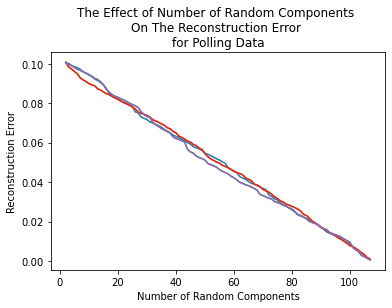

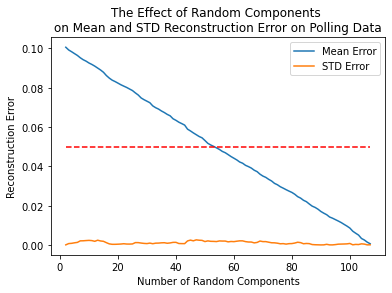

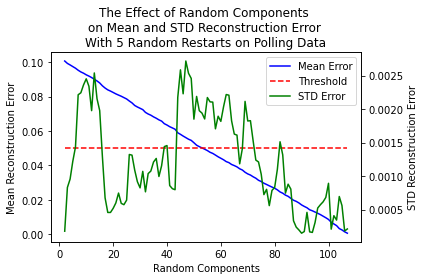

7.382772922515869


In [1022]:
start = time.time()

run_RCA(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

- For Data #1, Reconstruction Error is minimized with maximum number of features included
- We can reach less than 5% error rate with 54 number of components 

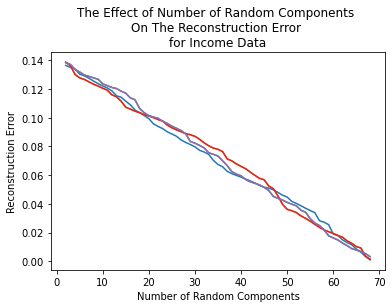

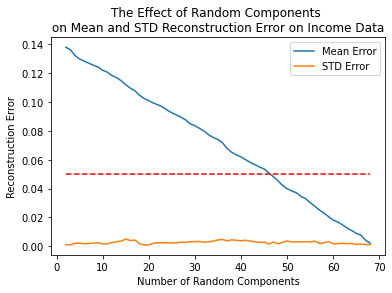

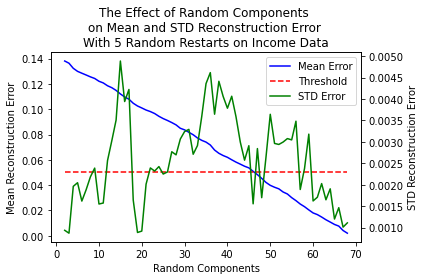

3.6194040775299072


In [1023]:
start = time.time()

run_RCA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

- RCA, Data #2 Requires 47 components

### Step 2.4) Random Forest Classifier

We can use Y in this Dimensionality Reduction Algorithm

In [705]:
from sklearn.ensemble import RandomForestClassifier as RFC

# How many features do we need to get 95% of feature importance? 
def RFC_min_samples_leaf(X_Data, Y_Data, title):
    
    # The Data is 7000 rows long, 70 is 1% of that 
    num_samples_leaf = np.arange(2, 72, 1)
    num_components_list = []
    
    for num in num_samples_leaf:
    
        rfc = RFC(n_estimators=100, min_samples_leaf= num, random_state=42)
        importances = rfc.fit(X_Data, Y_Data).feature_importances_ 

        importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
        importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
        importances['Cum Sum'] = importances['Feature Importance'].cumsum()
        importances = importances[importances['Cum Sum']<=0.95]
        top_cols = importances.index.tolist()

        #return (importances, top_cols)
        num_components_list.append(len(top_cols))
        
    plt.plot(num_samples_leaf, num_components_list)
    plt.xlabel("Number of Min Leaf Samples")
    plt.ylabel("Number of Components to get 95%")
    plt.title("The Effect of Min Leaf Samples Size \nOn Number of Components in Random Forest \nFor "+ title)
    plt.show()
    

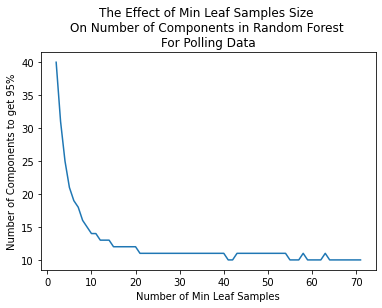

27.003655910491943


In [706]:
start = time.time()

RFC_min_samples_leaf(X_Train_Polling, Y_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Data # 1 should have 12 as the min_samples_leaf size

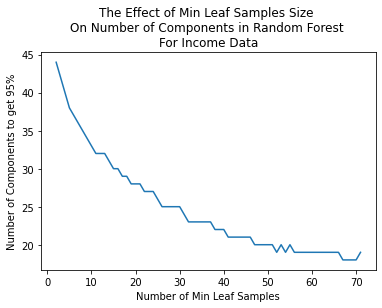

21.09196424484253


In [707]:
start = time.time()

RFC_min_samples_leaf(X_Train_Income, Y_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Data #2 should have ~47 as the min_samples_leaf size 

In [708]:
from sklearn.ensemble import RandomForestClassifier as RFC

# How many features do we need to get 95% of feature importance? 
def run_RFC(X_Data, Y_Data, min_samples):
    
    rfc = RFC(n_estimators=100, min_samples_leaf=min_samples, random_state=42)
    
    importances = rfc.fit(X_Data, Y_Data).feature_importances_ 
    
    importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
    importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    importances['Cum Sum'] = importances['Feature Importance'].cumsum()
    importances = importances[importances['Cum Sum']<=0.95]
    top_cols = importances.index.tolist()
    
    return (importances, top_cols)

In [709]:
importances, top_cols = run_RFC(X_Train_Polling, Y_Train_Polling, 12)

print(importances.shape)

importances

(13, 2)


,Feature Importance,Cum Sum
approval_pres_Strongly Disapprove,0.397137,0.397137
approval_pres_Strongly Approve,0.187498,0.584635
economy_retro_Gotten Much Better,0.105779,0.690414
approval_pres_Approve / Somewhat Approve,0.082038,0.772452
economy_retro_Stayed About The Same,0.035982,0.808434
economy_retro_Gotten Worse / Somewhat Worse,0.031179,0.839612
economy_retro_Gotten Better / Somewhat Better,0.026024,0.865636
race_Black,0.025846,0.891483
race_White,0.018611,0.910093
approval_pres_Disapprove / Somewhat Disapprove,0.013091,0.923185


- Dataset #1 Only requires 13 features to explain 95% of the results, using Random Forest Classifer 

In [710]:
importances, top_cols  = run_RFC(X_Train_Income, Y_Train_Income, 47)

print(importances.shape)

importances

(20, 2)


,Feature Importance,Cum Sum
marital.status_Married-civ-spouse,0.222067,0.222067
relationship_Husband,0.157912,0.379979
age_band_Young,0.071949,0.451929
marital.status_Never-married,0.060349,0.512278
occupation_Exec-managerial,0.054112,0.566390
hours_band_High,0.053364,0.619754
education_Bachelors,0.043697,0.663451
occupation_Prof-specialty,0.042281,0.705732
hours_band_Low,0.031157,0.736889
sex_Female,0.026713,0.763602


- Dataset #2, only Needs 19 components to get 95% of the feature importance using Random Forest Classifier

## Step 3)

In [712]:
pca = PCA(n_components = 31, random_state = 42)
pca.fit(X_Train_Polling)
pca.components_

kmeans = KMeans(init = pca.components_, n_clusters = 31, n_init =1, random_state = 42)
kmeans.fit(X_Train_Polling)

print("Inertia", kmeans.inertia_)
print("Labels:", kmeans.labels_)


s_score = silhouette_score(X_Train_Polling, kmeans.labels_ )
print(s_score)

Inertia 33673.02886766231
Labels: [ 2 27  4 ... 13  0  0]
0.052822607933396284


### Step 3) Data 1 

In [1024]:
pca_X_Train_Polling = PCA(n_components = 31, random_state = 42).fit_transform(X_Train_Polling)
ica_X_Train_Polling = ICA(n_components = 98, random_state = 42).fit_transform(X_Train_Polling)
rca_X_Train_Polling = GRP(n_components = 54, random_state = 42).fit_transform(X_Train_Polling)

In [1025]:
top_cols_df, top_cols = run_RFC(X_Train_Polling, Y_Train_Polling, 12)
rfc_X_Train_Polling = X_Train_Polling[top_cols] 

### Step 3) Data 1 With K-Means

Step 3.1) Data 1 With K-Means with PCA 

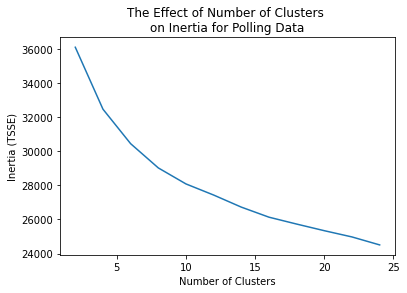

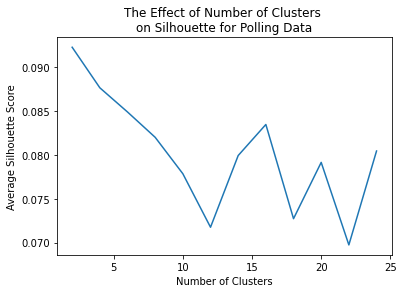

13.42261004447937


In [1026]:
start = time.time()

run_kmeans(pca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

Step 3.2) Data 1 With K-Means with ICA

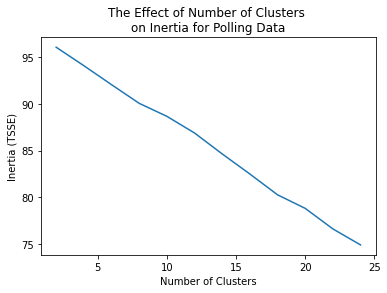

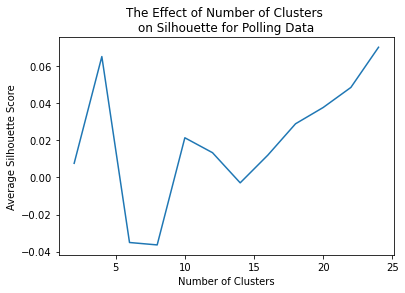

13.529636859893799


In [1027]:
start = time.time()

run_kmeans(ica_X_Train_Polling, np.arange(2, 25, 2), "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

- ICA for Data 1, reduced dataset, shows that the optimal number of clusters may not be 2 if we are using ICA 
- Optimal Clusters is 8 - 11

Step 3.3) Data 1 With K-Means with RCA 

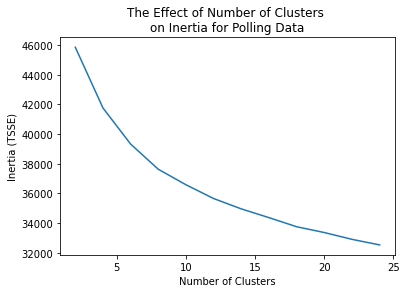

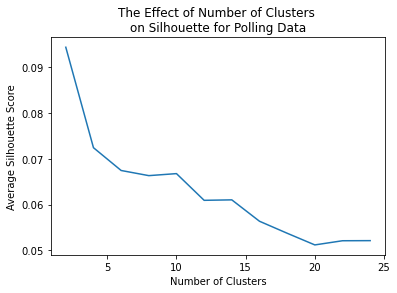

15.141815185546875


In [1028]:
start = time.time()

run_kmeans(rca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

Step 3.4) Data 1 with K-Means and RFC 

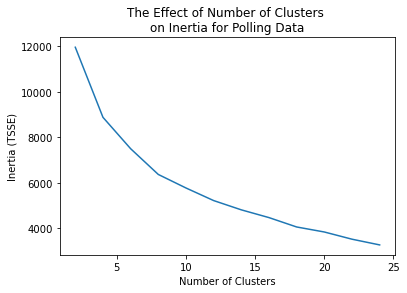

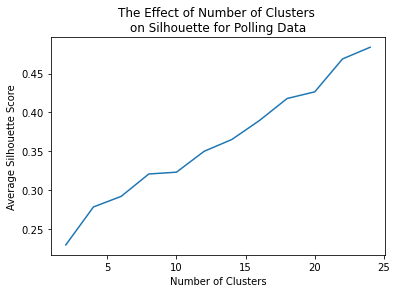

10.693794012069702


In [1029]:
start = time.time()

run_kmeans(rfc_X_Train_Polling, np.arange(2, 25, 2), "Polling Data" )

end = time.time()
elapsed = end - start
print(elapsed)

### Step 3) Data 1 With EM

3.5) Data 1 With EM with PCA 

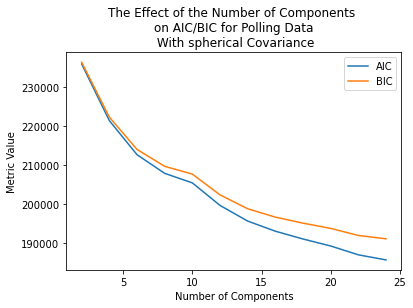

Silhouettes [0.09230764122148996, 0.07761773155944246, 0.07582876196043235, 0.07456619063328039, 0.057672295391423295, 0.07071096679299056, 0.06713758346487085, 0.07466605744351701, 0.069431153772913, 0.06184220467369414, 0.05316383397315207, 0.047440452710365746]


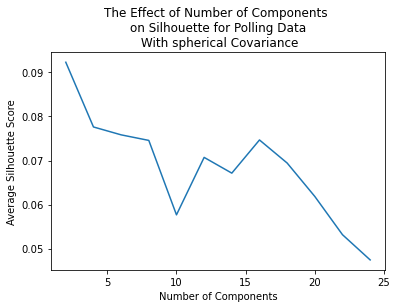

10.358737707138062


In [1030]:
start = time.time()

run_em(pca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

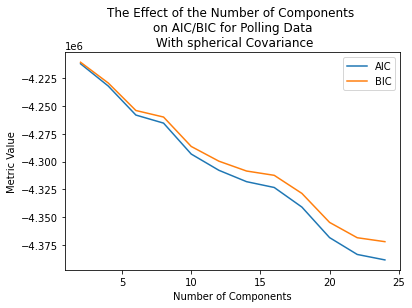

Silhouettes [0.19133956659328202, 0.013777119845324263, 0.011838383289534172, -0.036689879003039244, -0.035021956989966394, -0.016852137235035147, -0.018283255353748355, -0.00892107150195708, -0.0021797750902520963, 0.013467414415378956, 0.024204641599586234, 0.021274783725069375]


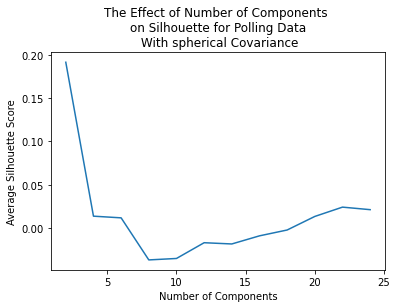

11.1576509475708


In [1031]:
start = time.time()

run_em(ica_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

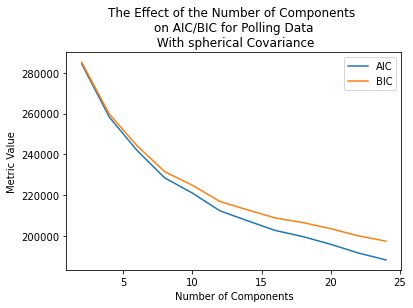

Silhouettes [0.09266936531636999, 0.06975141591567198, 0.07204162237143921, 0.06243937207036836, 0.05144309944530661, 0.049357278635533956, 0.04779362762112357, 0.04425632765019314, 0.04152314758890441, 0.04196961328453635, 0.040734077369409406, 0.04128684462696447]


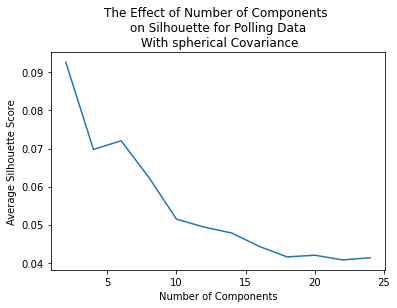

10.263178825378418


In [1032]:
start = time.time()

run_em(rca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

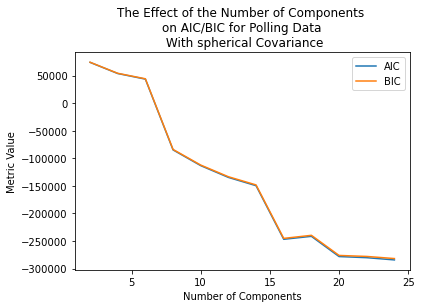

Silhouettes [0.1854490686511494, 0.17100506220351488, 0.22911426081625694, 0.2309885578979665, 0.2601426314882562, 0.27841608910791305, 0.31703938256954006, 0.34927943315919563, 0.4020542038129833, 0.4281870075345365, 0.45468955848947085, 0.4658023182445024]


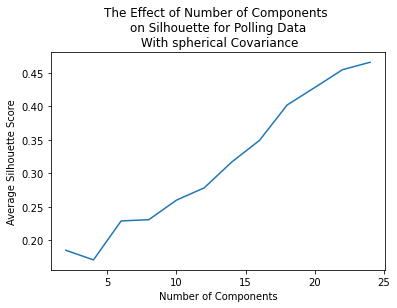

9.91782808303833


In [1033]:
start = time.time()

run_em(rfc_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

### Step 3) Data 2

In [1034]:
pca_X_Train_Income = PCA(n_components = 19, random_state = 42).fit_transform(X_Train_Income)
ica_X_Train_Income = ICA(n_components = 61, random_state = 42).fit_transform(X_Train_Income)
rca_X_Train_Income = GRP(n_components = 47, random_state = 42).fit_transform(X_Train_Income)

top_cols_df, top_cols = run_RFC(X_Train_Income, Y_Train_Income, 47)
rfc_X_Train_Income = X_Train_Income[top_cols] 

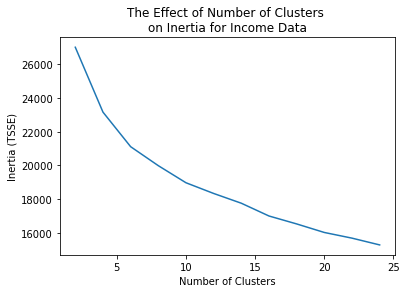

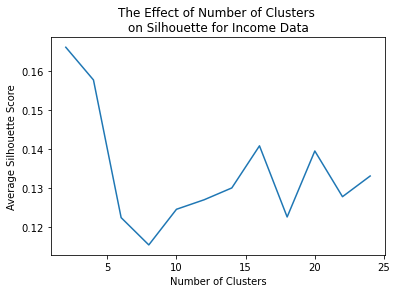

11.576425075531006


In [1036]:
start = time.time()

run_kmeans(pca_X_Train_Income, np.arange(2, 25, 2), "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

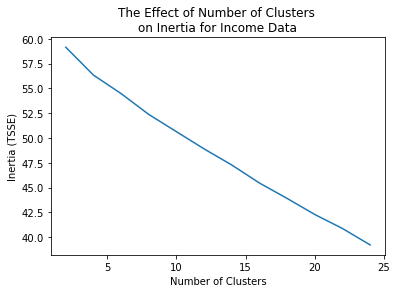

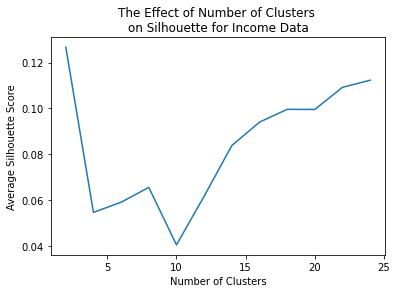

12.417774200439453


In [1037]:
start = time.time()

run_kmeans(ica_X_Train_Income, np.arange(2, 25, 2), "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

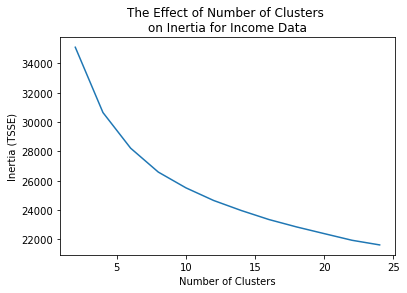

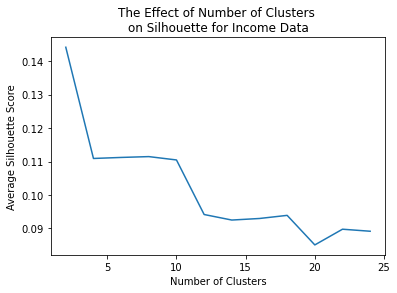

14.542226791381836


In [1038]:
start = time.time()

run_kmeans(rca_X_Train_Income, np.arange(2, 25, 2), "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

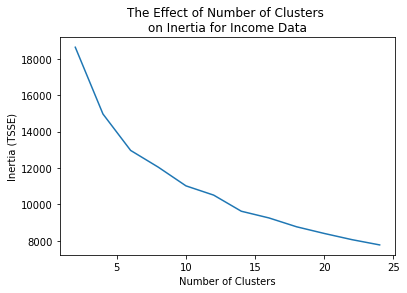

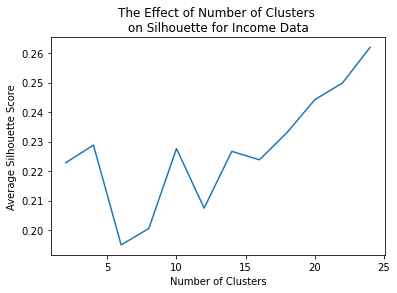

12.164706707000732


In [1039]:
start = time.time()

run_kmeans(rfc_X_Train_Income, np.arange(2, 25, 2), "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

Data 2 on EM

PCA

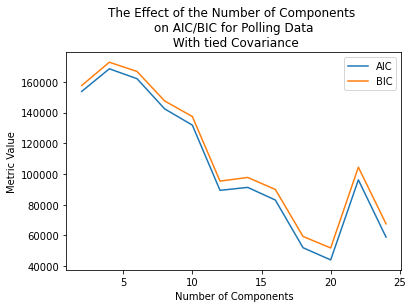

Silhouettes [0.09230764122148996, 0.07557817460850014, 0.07709745105699545, 0.07293957857657472, 0.06434402924460039, 0.07486112404257066, 0.06371846391571025, 0.07269571423170419, 0.07168216103735423, 0.05828597435611543, 0.0643549799837993, 0.06034306151759679]


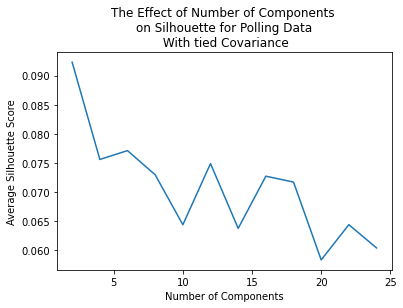

15.318012952804565


In [1040]:
start = time.time()

run_em(pca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

ICA

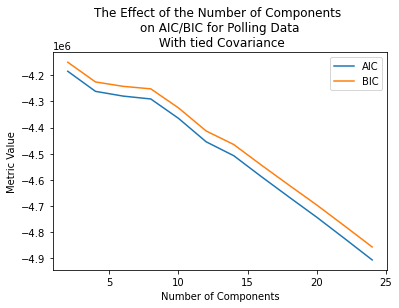

Silhouettes [0.08875090281938937, 0.007595636034795657, 0.018539520108994567, -0.01599749636261058, -0.0035732781690873253, 0.00790734152389045, -0.008251354265897626, 0.000551911984463851, 0.010623660676445032, 0.024180935870844054, 0.04064679763832144, 0.047333672869349926]


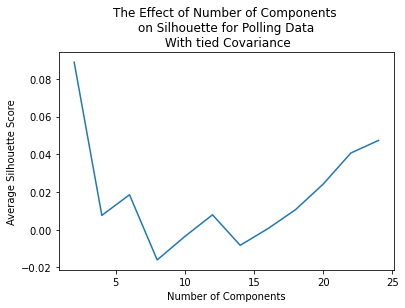

15.785248041152954


In [1041]:
start = time.time()

run_em(ica_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

RCA

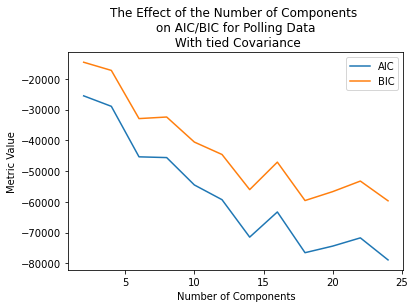

Silhouettes [0.09023165481421691, 0.060930525844884856, 0.06255324923409838, 0.05825226017974969, 0.03775696546570139, 0.04317409844416891, 0.03156712221411239, 0.04246462678109051, 0.02758803234917514, 0.027288614073656327, 0.03634989034136911, 0.03447550070204359]


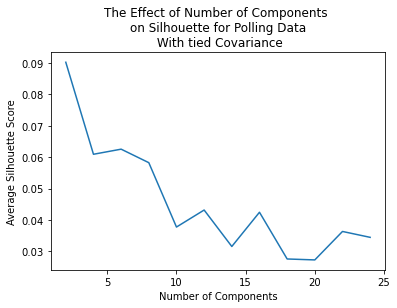

19.7677960395813


In [1042]:
start = time.time()

run_em(rca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

RFC

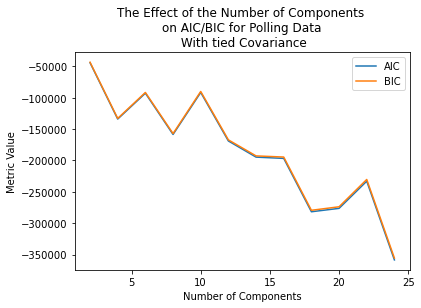

Silhouettes [0.224692188152751, 0.24260834207294998, 0.2910648073889838, 0.283625304492473, 0.2997329789843253, 0.3190971507313636, 0.3732203753353009, 0.37995372019716145, 0.38260551944634735, 0.41078460428440755, 0.43162875548666724, 0.4451482646509381]


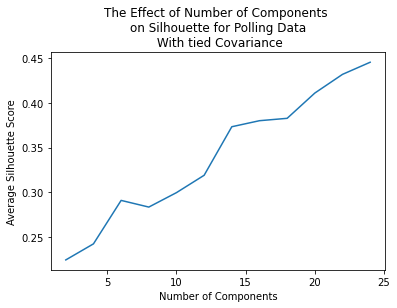

10.730503797531128


In [1043]:
start = time.time()

run_em(rfc_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

### Step 4: Use the Dimensionalty Reduced Datasets, Run Neural Networks 

In [1044]:
pca_X_Train_Polling.shape

(7000, 31)

In [1045]:
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import confusion_matrix

def make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, hidden_layer_sizes, activation, solver, LR_init):
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(pca_X_Train_Polling, Y_Train_Polling, test_size=0.30, random_state=42)


    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = LR_init, 
                                       hidden_layer_sizes = (hidden_layer_sizes,),
                                       activation = activation, solver=solver, max_iter=200)

    classifier.fit(X_Train, Y_Train)


    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    #print(f1_score)
    return(f1_score)
    #f1_scores_test.append(f1_score)

    #Y_Pred = classifier.predict(X_Train)
    #cm = confusion_matrix(Y_Train, Y_Pred)
    #tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
    #f1_score = (2*tp) / (2*tp + fp + fn)
    #print(f1_score)
    #f1_scores_train.append(f1_score)


Data #1

#### Activation Function

PCA

In [1046]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


F1 Score: 0.9234527687296417 Activation:  identity
F1 Score: 0.8965238480194018 Activation:  tanh
F1 Score: 0.8981891348088531 Activation:  relu
F1 Score: 0.9037690457097033 Activation:  logistic


ICA

In [1047]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


F1 Score: 0.9230145867098866 Activation:  identity
F1 Score: 0.9230145867098866 Activation:  tanh
F1 Score: 0.9017713365539453 Activation:  relu
F1 Score: 0.9222042139384117 Activation:  logistic


RCA

In [1048]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


F1 Score: 0.9209225700164745 Activation:  identity
F1 Score: 0.8938231731933791 Activation:  tanh
F1 Score: 0.899119295436349 Activation:  relu
F1 Score: 0.8993558776167472 Activation:  logistic


RFC

In [1049]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


F1 Score: 0.9235104669887279 Activation:  identity
F1 Score: 0.9246963562753037 Activation:  tanh
F1 Score: 0.9210950080515298 Activation:  relu
F1 Score: 0.9243765084473049 Activation:  logistic


In [1050]:
print("PCA:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01))
print("ICA:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 156, 'tanh', 'adam', 0.01))
print("RCA:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01))
print("RFC:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 156, 'tanh', 'adam', 0.01))

PCA: 0.9234527687296417
ICA: 0.9230145867098866
RCA: 0.9209225700164745
RFC: 0.9246963562753037


#### Hidden Layer Sizes

PCA

[0.925264012997563, 0.9245663574021783, 0.921760391198044, 0.9236980218005651, 0.9225780299959465, 0.9243833400727861, 0.9248788368336026, 0.9248181083265966, 0.9245663574021783, 0.9224522939504669, 0.9220146222583265, 0.9253128784820347, 0.9248181083265966, 0.9224522939504669, 0.9225152129817444]


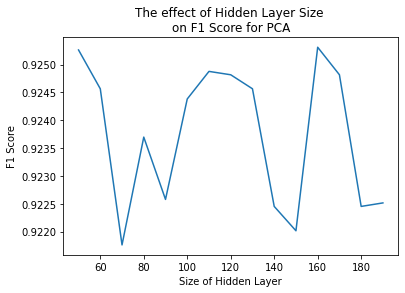

In [1051]:
f1_score_list = []
hidden_layers_list = np.arange(50, 200, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, HL, 'identity', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for PCA")
plt.show()   

ICA

[0.9245663574021783, 0.9243833400727861, 0.9235082098518221, 0.9232012934518997, 0.9236393176279447, 0.921968787515006, 0.9237595804759984, 0.9250203748981255, 0.9230769230769231, 0.9233870967741935, 0.9243421052631579, 0.9208747514910537, 0.9235173824130879, 0.9218939700526103, 0.922509225092251]


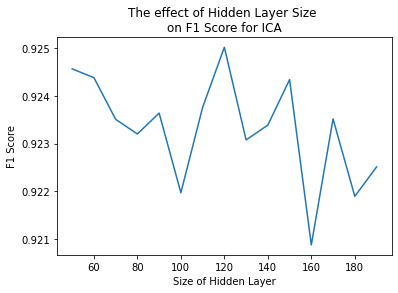

In [1052]:
f1_score_list = []
hidden_layers_list = np.arange(50, 200, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, HL, 'tanh', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for ICA")
plt.show()   

RCA

[0.9219571370804691, 0.9222042139384117, 0.9210950080515298, 0.9230145867098866, 0.9229534510433387, 0.9239482200647249, 0.9227625664078464, 0.9220831651190957, 0.9240146281999188, 0.9218813905930471, 0.9227033589639821, 0.9231398201144726, 0.9240097008892482, 0.9222042139384117, 0.9225700164744646]


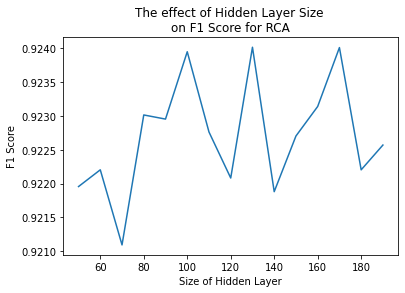

In [1053]:
f1_score_list = []
hidden_layers_list = np.arange(50, 200, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, HL, 'identity', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for RCA")
plt.show()   

RFC

[0.9230769230769231, 0.924322136786726, 0.9233870967741935, 0.9245054501412999, 0.9229528035498185, 0.9220146222583265, 0.9217038539553752, 0.9227033589639821, 0.9217741935483871, 0.9241268566840626, 0.9228295819935691, 0.9238249594813615, 0.9251920744035584, 0.9250708788983394, 0.9245054501412999]


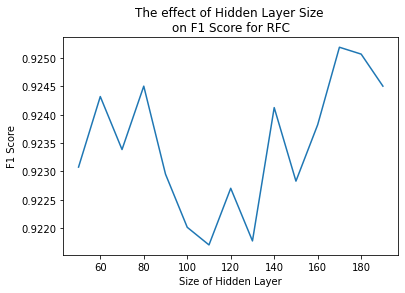

In [1054]:
f1_score_list = []
hidden_layers_list = np.arange(50, 200, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, HL, 'tanh', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for RFC")
plt.show()   

#### Best So far

In [1056]:
print("PCA:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', 0.01))
print("ICA:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', 0.01))
print("RCA:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 130, 'identity', 'adam', 0.01))
print("RFC:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', 0.01))

PCA: 0.9248181083265966
ICA: 0.9250203748981255
RCA: 0.9240146281999188
RFC: 0.9251920744035584


#### Initial Learning Rate

PCA

[0.9225780299959465, 0.9238866396761134, 0.9248181083265966, 0.9148514851485149, 0.8983320095313742, 0.8758592802264457]


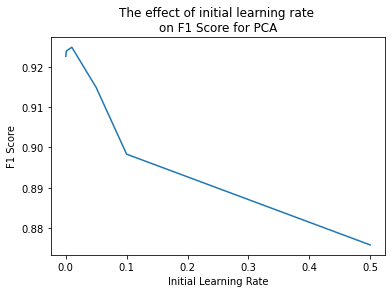

In [1057]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', LR)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for PCA")
plt.show()   

ICA

[0.8798751950078003, 0.9235746057420138, 0.9250203748981255, 0.92542101042502, 0.9238289205702648, 0.9087187883749488]


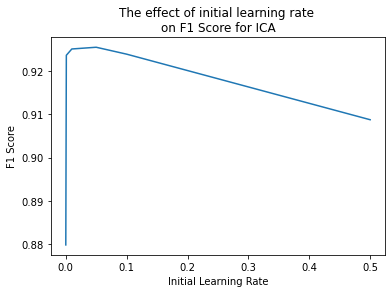

In [1058]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', LR)
    f1_score_list.append(f1_score)

print(f1_score_list)
 
plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for ICA")
plt.show()   

RCA

[0.9238249594813615, 0.9214574898785425, 0.9240146281999188, 0.9140378548895899, 0.917979797979798, 0.912714228776405]


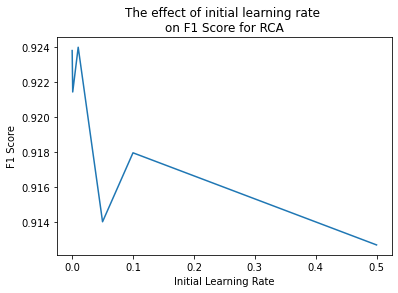

In [1059]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 130, 'identity', 'adam', LR)
    f1_score_list.append(f1_score)
    
print(f1_score_list)

plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for RCA")
plt.show()   

RFC

[0.9223261488409923, 0.9232643118148599, 0.9251920744035584, 0.9249899719213799, 0.9224, 0.6806943713834824]


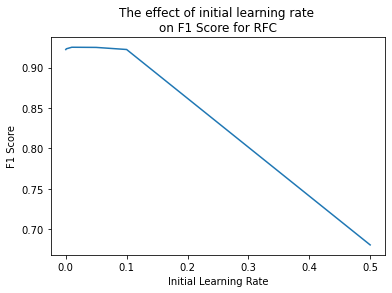

In [1060]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', LR)
    f1_score_list.append(f1_score)

print(f1_score_list)
 
plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for RFC")
plt.show()   

#### Best Results

In [1062]:
print("Full:", make_ann_dimred(X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01))

Full: 0.9223300970873787


In [1061]:
print("PCA:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', 0.01))
print("ICA:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', 0.05))
print("RCA:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 130, 'identity', 'adam', 0.01))
print("RFC:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', 0.01))

PCA: 0.9248181083265966
ICA: 0.92542101042502
RCA: 0.9240146281999188
RFC: 0.9251920744035584



### Step 5: Apply Clustering Algorithms, then use those labels to feed into a Neural Network

Make one Prediction for KM, and one for EM

In [941]:
X_Data = X_Train_Polling
Y_Data = Y_Train_Polling

kmeans =  KMeans(n_clusters = 31, init = 'k-means++', n_init = 10, random_state = 42)
kmeans_labels = kmeans.fit_predict(X_Data)

#em = EM(n_components = em_clusters, covariance_type = 'spherical', n_init = 1, init_params = 'kmeans', random_state = 42)
#em_labels = em.fit_predict(X_Data)

#nn_labels = pd.DataFrame([kmeans_labels, em_labels], index = ['KM', 'EM']).T
kmeans_labels = pd.DataFrame(kmeans_labels, columns = ['KM'])

# Add the NN Labels Here:
#X_Train, X_Test, Y_Train, Y_Test = train_test_split(nn_labels, Y_Data, test_size=0.30, random_state=42)
#X_Train, X_Test, Y_Train, Y_Test = prep_data(nn_labels, Y_Data, ['KM', 'EM'])
X_Train, X_Test, Y_Train, Y_Test = prep_data(kmeans_labels, Y_Data, ['KM'])

classifier = MLPClassifier(random_state=42,
                                   learning_rate_init = 0.01, 
                                   hidden_layer_sizes = (156,),
                                   activation = 'identity', solver='adam', max_iter=200)
classifier.fit(X_Train, Y_Train)

Y_Pred = classifier.predict(X_Test)
cm = confusion_matrix(Y_Test, Y_Pred)
tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
f1_score = (2*tp) / (2*tp + fp + fn)
print(f1_score)

0.8967666536813401


In [884]:
def make_ann_cluster(X_Data, Y_Data, km_clusters, em_clusters, hidden_layer_size, activation, solver, LR):
    
    kmeans =  KMeans(n_clusters = km_clusters, init = 'k-means++', n_init = 10, random_state = 42)
    kmeans_labels = kmeans.fit_predict(X_Data)
    
    em = EM(n_components = em_clusters, covariance_type = 'spherical', n_init = 1, init_params = 'kmeans', random_state = 42)
    em_labels = em.fit_predict(X_Data)
    
    #nn_labels = np.array([kmeans_labels, em_labels]).T
    nn_labels = pd.DataFrame([kmeans_labels, em_labels], index = ['KM', 'EM']).T
    
    # Add the NN Labels Here:
    #X_Train, X_Test, Y_Train, Y_Test = train_test_split(nn_labels, Y_Data, test_size=0.30, random_state=42)
    X_Train, X_Test, Y_Train, Y_Test = prep_data(nn_labels, Y_Data, ['KM', 'EM'])
    
    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = LR, 
                                       hidden_layer_sizes = (hidden_layer_size,),
                                       activation = activation, solver=solver, max_iter=200)
    classifier.fit(X_Train, Y_Train)

    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print(f1_score)

Full Dataset, No Dimensionality Reduction before Clustering

In [1080]:
make_ann_cluster(X_Train_Polling, Y_Train_Polling, 10, 5, 156, 'identity', 'adam', 0.01)

(7000, 2)
0.8941082802547771


PCA

In [890]:
make_ann_cluster(pca_X_Train_Polling, Y_Train_Polling, 31, 31, 170, 'identity', 'adam', 0.01)

(7000, 2)
0.9024583663758922


ICA

In [936]:
make_ann_cluster(ica_X_Train_Polling, Y_Train_Polling, 98, 98, 120, 'tanh', 'adam', 0.01)

(7000, 2)
0.6953937592867756


RCA

In [892]:
make_ann_cluster(rca_X_Train_Polling, Y_Train_Polling, 58, 58, 110, 'identity', 'adam', 0.0001)

(7000, 2)
0.9036918138041734


RFC

In [889]:
make_ann_cluster(rfc_X_Train_Polling, Y_Train_Polling, 13, 13, 170, 'tanh', 'adam', 0.01)

(7000, 2)
0.9141914191419142


In [943]:
em_labels.shape

(7000,)

In [942]:
kmeans_labels.shape

(7000, 0)

In [844]:
nn_labels.shape

(7000, 2)